### Adopting RNN, LSTM to build Air pollution forecasting Deep Neural Network

In [ ]:

import os

import matplotlib
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
# import h5py
import math, scipy
import missingno as msno
from scipy import ndimage
import sklearn

import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, LeakyReLU, ReLU, Dropout, Dense, Bidirectional, Conv1D, Lambda
from keras.preprocessing.sequence import TimeseriesGenerator
import keras

%matplotlib inline
plt.style.use( 'dark_background' )
pd.set_option('display.max_columns', None)
np.random.seed(1) # set a seed so that the results are consistent

location = 'datasets/'

<br>

##### Prepare Input data with TimeseriesGenerator to `-->` Forecast Air Pollution

In [ ]:
air_df = pd.read_csv( 'datasets/BE_1_2013-2015_aggregated_timeseries.csv', sep= '\t', parse_dates= [ 'DatetimeBegin', 'DatetimeEnd' ] )

metaData_df = pd.read_csv( 'datasets/BE_2013-2015_metadata.csv', sep= '\t' )

print( air_df.shape ); air_df.head(3)

(53647, 18)


,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,AirPollutant,AirPollutantCode,DataAggregationProcess,AirPollutionLevel,UnitOfAirPollutionLevel,DataCapture,DataCoverage,TimeCoverage,DatetimeBegin,DatetimeEnd,Validity,Verification
0,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,83.333333,83.333333,2013-03-01,2013-03-02,1,1
1,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-02-26,2013-02-27,1,1
2,BE,BE.CELINE-IRCEL.AQ,NET-Flanders,STA-BELBE06,BELBE06,SPO-BELBE06_00001_100,SO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,P1D,1.0,µg/m3,100.0,87.500000,87.500000,2013-08-28,2013-08-29,1,1


#### EDA

Let's use **pandas_profiling** to inspect the data. The pandas_profiling report learns us the following:

* There are 6 constant variables. We can remove these from the data set.
* No missing values exist, so probably we will not need to apply imputation.
* **AirPollutionLevel** has some zeroes, but this could be perfectly normal. On the other hand, this variables has some extreme values, which might be incorrect recordings of the air pollution.
* There are 53 **AirQualityStations**, which are probably the same as the **SamplingPoints**. **AirQualityStationEoICode** is simply an shorter code for the AirQualityStation, so that variable can also be removed.
* There are 3 values for **AirQualityNetwork** (Brussels, Flanders and Wallonia). Most measurements come from Flanders.
* **DataAggregationProcess**: most rows contain data aggregated as the 24-hour mean of one day of measurements (P1D). More information on the other values can be found [here](http://dd.eionet.europa.eu/vocabulary/aq/aggregationprocess). In this project we will only consider P1D values.
* **DataCapture**: Proportion of valid measurement time relative to the total measured time (time coverage) in the averaging period, expressed as percentage. Almost all rows have about 100% of valid measurement time. Some rows have a DataCapture that is slightly lower than 100%.
* **DataCoverage**: Proportion of valid measurement included in the aggregation process within the averaging period, expressed as percentage. In this data set we have a minimum of 75%. According to the [definition of this variable](https://www.eea.europa.eu/data-and-maps/data/aqereporting-2/be) values below 75% should not be included for air quality assessments, which explains why these rows are not present in the data set.
* **TimeCoverage**: highly correlated to DataCoverage and will be removed from the data.
* **UnitOfAirPollutionLevel**: 423 rows have a unit of *count*. To have a consistent target variable we will remove the records with this type of unit.
* **DateTimeBegin** and **DateTimeEnd**: the histogram does not provide enough detail here. This needs to be analyzed further.



C:\Users\madhur\AppData\Local\Temp/ipykernel_13972/1641790162.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.tight_layout(); plt.show()


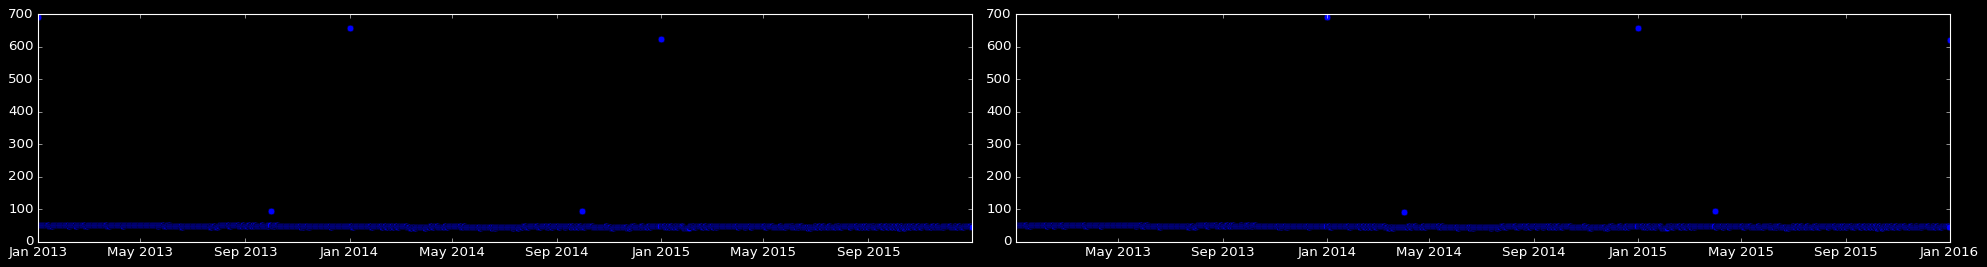

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,3.5) )

ax[0].plot( air_df.groupby( 'DatetimeBegin' ).count() , 'o', color= 'blue' );
ax[1].plot( air_df.groupby( 'DatetimeEnd' ).count() , 'o', color= 'blue' );

plt.tight_layout(); plt.show()

In [ ]:
air_df[ ['AirQualityNetwork', 'SamplingPoint', 'AirPollutionLevel', 'DataCoverage', 'DatetimeBegin' ]].head(3)

,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage,DatetimeBegin
0,NET-Flanders,SPO-BELBE06_00001_100,1.0,83.333333,2013-03-01
1,NET-Flanders,SPO-BELBE06_00001_100,1.0,87.500000,2013-02-26
2,NET-Flanders,SPO-BELBE06_00001_100,1.0,87.500000,2013-08-28


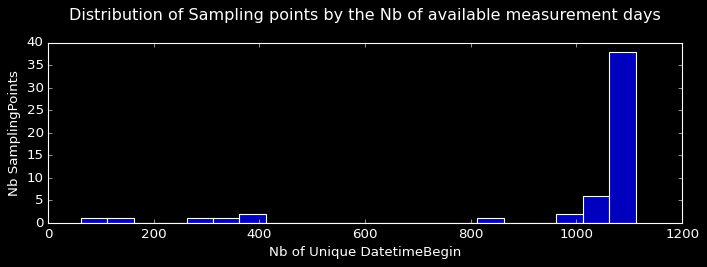

In [ ]:
samplePt_grp = air_df.groupby( 'SamplingPoint' ).nunique()['DatetimeBegin']\
                                                    .sort_values( ascending= False )
fg, ax = plt.subplots( figsize= (9,3.5) )

sns.histplot( x= samplePt_grp, binwidth= 50  )

ax.set_xlabel( 'Nb of Unique DatetimeBegin' );  ax.set_ylabel( 'Nb SamplingPoints' )
ax.set_title( 'Distribution of Sampling points by the Nb of available measurement days\n' )
plt.tight_layout()

<br>

### Data Preparation

#### Data Cleaning
Based on the data exploration, we will do the following to clean the data:
* Keeping only records with DataAggregationProcss of P1D
* Removing records with `UnitOfAirPollutionLevel` = `count`
* Removing unary variables and other redundant variables
* Removing SamplingPoints which have less than 1000 measurement days

In [ ]:
conditions = ( air_df.DataAggregationProcess == 'P1D' ) & ( air_df.UnitOfAirPollutionLevel != 'count' ) & \
             ( air_df.SamplingPoint.isin( samplePt_grp[ samplePt_grp >= 1000 ].index ) )

cols_to_keep = [ 'AirQualityNetwork', 'SamplingPoint', 'AirPollutionLevel', 'DataCoverage', 'DatetimeBegin' ]

air_df = air_df.loc[  conditions, cols_to_keep  ]

# making datetime as the index for easy operation
air_df.set_index( 'DatetimeBegin', inplace= True )

print( air_df.shape ); air_df.head()

(48319, 4)


,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage
DatetimeBegin,,,,
2013-05-22,NET-Flanders,SPO-BELHB23_00001_100,1.0,83.333333
2013-01-04,NET-Flanders,SPO-BELHB23_00001_100,1.0,87.500000
2013-02-25,NET-Flanders,SPO-BELHB23_00001_100,1.0,95.833333
2013-02-27,NET-Flanders,SPO-BELHB23_00001_100,1.0,95.833333
2013-03-11,NET-Flanders,SPO-BELHB23_00001_100,1.0,95.833333


##### Inserting rows for the missing timesteps

We can first `sort --> resample of 1 day --> backfill the empty records` using groupby for SamplingPoint

In [ ]:
air_df.head(3)

,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage
DatetimeBegin,,,,
2013-05-22,NET-Flanders,SPO-BELHB23_00001_100,1.0,83.333333
2013-01-04,NET-Flanders,SPO-BELHB23_00001_100,1.0,87.500000
2013-02-25,NET-Flanders,SPO-BELHB23_00001_100,1.0,95.833333


In [ ]:
samplePt_grp_obj =  air_df.groupby( 'SamplingPoint', as_index= False )
append_ls = []
for e_sampltPt, e_df in samplePt_grp_obj:
    append_ls.append(    samplePt_grp_obj.get_group( e_sampltPt ).sort_values( 'DatetimeBegin' ).resample('D').bfill( )   )

air_filled_df = pd.concat( append_ls );
print( air_filled_df.shape );  air_filled_df.head(3)

(49270, 4)


,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage
DatetimeBegin,,,,
2013-01-01,NET-Flanders,SPO-BELHB23_00001_100,28.195652,95.833333
2013-01-02,NET-Flanders,SPO-BELHB23_00001_100,55.978261,95.833333
2013-01-03,NET-Flanders,SPO-BELHB23_00001_100,2.666667,100.000000


##### confirmation that the resampling and back-filling worked

In [ ]:
air_df.loc[ ( air_df['SamplingPoint'] == 'SPO-BETR223_00001_100' ),:  ].sort_index()[26:31]

,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage
DatetimeBegin,,,,
2013-01-27,NET-Wallonia,SPO-BETR223_00001_100,6.891304,95.833333
2013-01-28,NET-Wallonia,SPO-BETR223_00001_100,2.681818,91.666667
2013-03-01,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-03-02,NET-Wallonia,SPO-BETR223_00001_100,1.916667,100.000000
2013-03-03,NET-Wallonia,SPO-BETR223_00001_100,2.282609,95.833333


In [ ]:
air_filled_df.loc[ ( air_filled_df['SamplingPoint'] == 'SPO-BETR223_00001_100' ),:  ].sort_index()[26:34]

,AirQualityNetwork,SamplingPoint,AirPollutionLevel,DataCoverage
DatetimeBegin,,,,
2013-01-27,NET-Wallonia,SPO-BETR223_00001_100,6.891304,95.833333
2013-01-28,NET-Wallonia,SPO-BETR223_00001_100,2.681818,91.666667
2013-01-29,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-01-30,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-01-31,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-02-01,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-02-02,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000
2013-02-03,NET-Wallonia,SPO-BETR223_00001_100,1.261905,87.500000


#### Handling multiple time series

We have data for multiple sampling points. So we have multiple timeseries.

One way to deal with that is to:

    - create dummy variables for the samplingpoints and use all records to train the model
    - Another way is to build a separate model per samplingpoint.

Here, we will do the latter. We will, however, limit the notebook to do that for only one `samplingpoint`. But the same logic can be applied to every samplingpoint.

In [ ]:
air_SamplePt1_df = air_filled_df[  air_filled_df['SamplingPoint'] == 'SPO-BETR223_00001_100' ]
air_SamplePt1_df.drop( columns= 'SamplingPoint', inplace= True )
print( air_SamplePt1_df.shape ) ; air_SamplePt1_df.head(3)

(1095, 3)


C:\Users\madhur\AppData\Local\Temp/ipykernel_13972/3596305040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_SamplePt1_df.drop( columns= 'SamplingPoint', inplace= True )


,AirQualityNetwork,AirPollutionLevel,DataCoverage
DatetimeBegin,,,
2013-01-01,NET-Wallonia,1.847826,95.833333
2013-01-02,NET-Wallonia,0.000000,100.000000
2013-01-03,NET-Wallonia,0.000000,95.833333


#### Split `train,` `test ` & `validation set`

We split off a test set in order to evaluate the performance of the model. The test set will not be used during the training phase.

    train set : data until <= July 2014
    validation set : 6 months between July 2014 - January 2015
    test set : data of 2015

  2013-01-01 00:00:00 2014-06-30 00:00:00 
  2014-07-01 00:00:00 2014-12-31 00:00:00 
  2015-01-01 00:00:00 2015-12-31 00:00:00


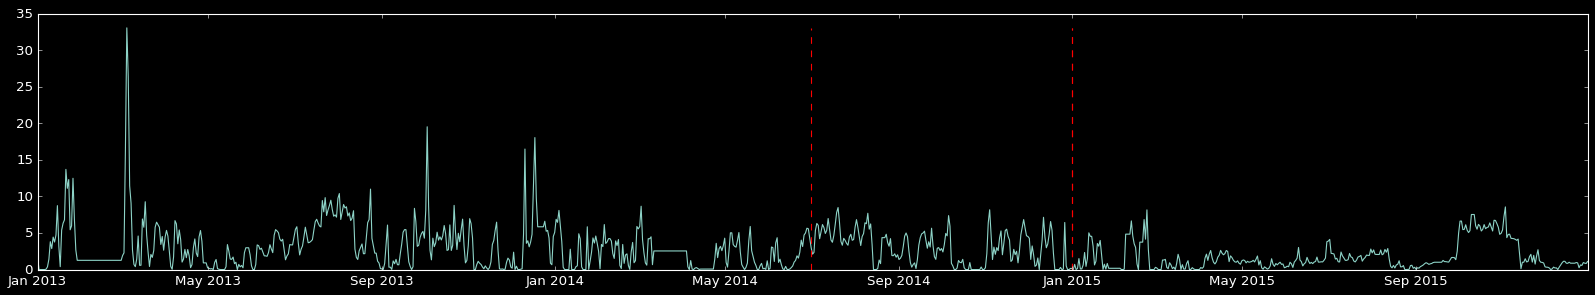

In [ ]:
trn = air_SamplePt1_df.query(  " DatetimeBegin  < '2014-07-01' "  )
valid = air_SamplePt1_df.query(  " DatetimeBegin >= '2014-07-01' and DatetimeBegin < '2015-01-01' "  )
tst = air_SamplePt1_df.query(  " DatetimeBegin >= '2015-01-01' "  )

print( ' ', trn.index.min(),trn.index.max(),'\n ',valid.index.min(), valid.index.max(),'\n ',tst.index.min(),tst.index.max() )

fg, ax = plt.subplots( figsize= (25,4) )

ax.plot( air_SamplePt1_df.AirPollutionLevel )
ax.vlines(  x= [ '2014-07-01',  '2015-01-01', '2015-01-01' ], ymin= np.min(air_SamplePt1_df.AirPollutionLevel), ymax= np.max(air_SamplePt1_df.AirPollutionLevel),
            color= 'red' , linestyle= '--'  );

In [ ]:
# normalization

normScaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )

trn_norm_np = normScaler_obj.fit_transform( trn[['AirPollutionLevel']] )
valid_norm_np = normScaler_obj.fit_transform( valid[['AirPollutionLevel']] )
tst_norm_np = normScaler_obj.fit_transform( tst[['AirPollutionLevel']] )

print( trn_norm_np.shape, '\t', valid_norm_np.shape, '\t', tst_norm_np.shape )

(546, 1) 	 (184, 1) 	 (365, 1)


<br>

#### Prepare data with the `TimeseriesGenerator`

The [TimeseriesGenerator of Keras](https://keras.io/preprocessing/sequence/#timeseriesgenerator) helps us building the data in the correct format for modeling.

* **length** : number of timesteps in the generated sequence. Here we want to look back an arbitrary number of *`n_lag`* timesteps. In reality n_lag could depend on how the predictions will be used. Suppose the Belgian government can take some actions to reduce the SO2 pollution around a samplingpoint (for instance prohibit the entrance of diesel cars in a city for a certain period of time). And suppose the government needs 14 days before the corrective actions can go in effect. Then it would make sense to set *`n_lag`* = 14.
* **sampling_rate** : number of timesteps between successive timesteps in the generated sequence. We want to keep all timesteps, so we leave this to the default of 1.
* **stride** : this parameter influences how much the generated sequences will overlap. As we do not have much data, we leave it to the default of 1. This means that two sequences generated after one another overlap with all timesteps except one.
* **batch_size** : number of generated sequences in each batch

In [ ]:
win_sz = 14

trn_genr   = keras.preprocessing.sequence.TimeseriesGenerator(  data= trn_norm_np,   targets= trn_norm_np,   length= win_sz, sampling_rate= 1, stride= 1  )
valid_genr = keras.preprocessing.sequence.TimeseriesGenerator(  data= valid_norm_np, targets= valid_norm_np, length= win_sz, sampling_rate= 1, stride= 1  )
tst_genr   = keras.preprocessing.sequence.TimeseriesGenerator(  data= tst_norm_np,   targets= tst_norm_np,   length= win_sz, sampling_rate= 1, stride= 1  )

<br>

#### Simple RNN model arch

In [ ]:
## RNN model arch

rnnModel = keras.Sequential()
rnnModel.add(  keras.layers.SimpleRNN( 4, input_shape= (win_sz,1) )  )
rnnModel.add(  keras.layers.Dense( 1 )  )

rnnModel.compile(  optimizer= 'rmsprop', loss= 'mae'  )

checkPoint_obj = keras.callbacks.ModelCheckpoint(  filepath= 'simpleRNN_wts_812.hdf5', verbose= 2, save_best_only= True  )

earlyStop_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', patience= 20, verbose= 2, min_delta= 1e-2  )


with open( 'simpleRNN_model_812.json', mode= 'w' ) as rnnModelFile:
    rnnModelFile.write( rnnModel.to_json() )

rnnModel_fit_genr = rnnModel.fit(  trn_genr, epochs= 1000, validation_data= valid_genr, callbacks= [ checkPoint_obj, earlyStop_obj ], verbose= 2  )

Epoch 1/1000

Epoch 00001: val_loss improved from inf to 0.76430, saving model to simpleRNN_wts_812.hdf5
5/5 - 1s - loss: 0.3101 - val_loss: 0.7643 - 779ms/epoch - 156ms/step
Epoch 2/1000

Epoch 00002: val_loss improved from 0.76430 to 0.72482, saving model to simpleRNN_wts_812.hdf5
5/5 - 1s - loss: 0.2513 - val_loss: 0.7248 - 686ms/epoch - 137ms/step
Epoch 3/1000

Epoch 00003: val_loss improved from 0.72482 to 0.69248, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.2214 - val_loss: 0.6925 - 154ms/epoch - 31ms/step
Epoch 4/1000

Epoch 00004: val_loss improved from 0.69248 to 0.66285, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.2010 - val_loss: 0.6629 - 132ms/epoch - 26ms/step
Epoch 5/1000

Epoch 00005: val_loss improved from 0.66285 to 0.63362, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.1847 - val_loss: 0.6336 - 138ms/epoch - 28ms/step
Epoch 6/1000

Epoch 00006: val_loss improved from 0.63362 to 0.60761, saving model to simpleRNN_wts_812.hdf5
5/5

Epoch 49/1000

Epoch 00049: val_loss did not improve from 0.16561
5/5 - 0s - loss: 0.0483 - val_loss: 0.1661 - 116ms/epoch - 23ms/step
Epoch 50/1000

Epoch 00050: val_loss improved from 0.16561 to 0.16392, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.0476 - val_loss: 0.1639 - 132ms/epoch - 26ms/step
Epoch 51/1000

Epoch 00051: val_loss did not improve from 0.16392
5/5 - 0s - loss: 0.0464 - val_loss: 0.1652 - 116ms/epoch - 23ms/step
Epoch 52/1000

Epoch 00052: val_loss improved from 0.16392 to 0.16038, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.0467 - val_loss: 0.1604 - 138ms/epoch - 28ms/step
Epoch 53/1000

Epoch 00053: val_loss improved from 0.16038 to 0.15941, saving model to simpleRNN_wts_812.hdf5
5/5 - 0s - loss: 0.0459 - val_loss: 0.1594 - 169ms/epoch - 34ms/step
Epoch 54/1000

Epoch 00054: val_loss did not improve from 0.15941
5/5 - 0s - loss: 0.0464 - val_loss: 0.1600 - 116ms/epoch - 23ms/step
Epoch 55/1000

Epoch 00055: val_loss improved from 0.15941

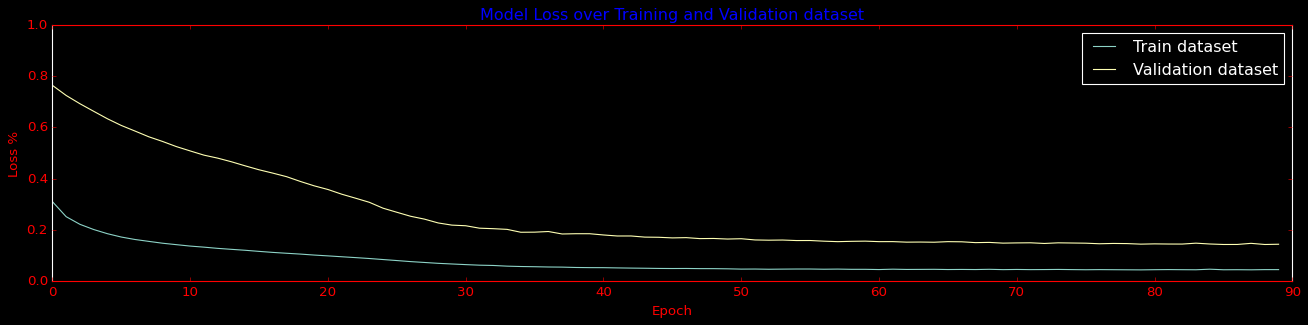

In [ ]:
plot_loss(  model_fitting_obj= rnnModel_fit_genr, ylim= [0,1], figsz= (20,4)  )


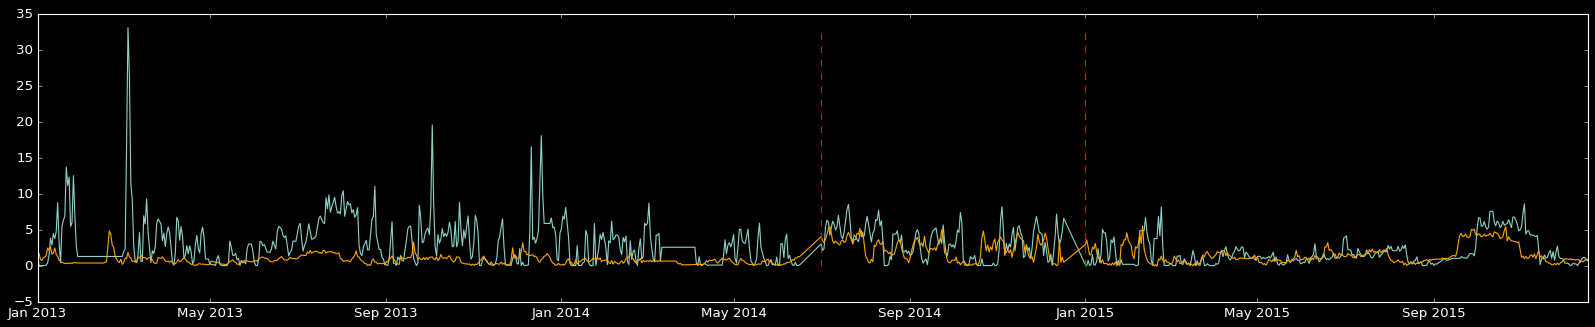

In [ ]:

# yhats
yhat_trn = rnnModel.predict( trn_genr )  ;   yhat_valid = rnnModel.predict( valid_genr );  yhat_tst = rnnModel.predict( tst_genr )

yhat = np.vstack(  [ normScaler_obj.inverse_transform(yhat_trn), normScaler_obj.inverse_transform(yhat_valid), normScaler_obj.inverse_transform(yhat_tst) ]  )

y = np.hstack(  [ trn[:-14]['AirPollutionLevel'].values, valid[:-14]['AirPollutionLevel'].values, tst[:-14]['AirPollutionLevel'].values ]  )

dateTime_idx = trn.index[:-14].union( valid.index[:-14] ).union( tst.index[:-14] )

fg, ax = plt.subplots( figsize= (25, 4.5) )

ax.plot( dateTime_idx, y )
ax.plot( dateTime_idx, yhat, color= 'orange' )
ax.vlines(  x= [ '2014-07-01',  '2015-01-01', '2015-01-01' ], ymin= np.min(air_SamplePt1_df.AirPollutionLevel), ymax= np.max(air_SamplePt1_df.AirPollutionLevel),
            color= 'red' , linestyle= '--'  );

<br>

<div id= '8.5.3'></div>

### 8.5.3 - Long Short Term Memory Networks to `-->` Forecast Air Pollution
*[Go to top](#toc)*

<h4>Long Short Term Memory Networks</h4>

An RNN has a short memory. It has difficulty remembering information from many timesteps ago. This occurs when the sequences are very long.
In fact, it is due to the *vanishing gradient* problem. When there exist many timesteps in the RNN, the gradient for the first layers becomes very tiny. As a result, the update of the weights of the first layers is negligible. This means that the RNN is not capable of effectively retaining and thus learning what was in the early layers.
So we need a way to carry the information of the first layers to later layers. LSTMs are better suited to take into account long-term dependencies.

<br>

#### Simple LSTM

In [ ]:
from keras.layers import Dense, LSTM, Bidirectional, Lambda

In [ ]:
model_LSTM = keras.Sequential()

model_LSTM.add(  layer= LSTM( units= 4, input_shape= [win_sz,1] )  )    # <--  input_shape = [ window_size, # features ]

model_LSTM.add(  layer= Dense( 1 )  )

model_LSTM.compile( optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= 'mae' )

checkPoint_obj = keras.callbacks.ModelCheckpoint( filepath= 'simpleLSTM_wts_040822.hdf5', save_best_only= True )
earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25, verbose= 1, mode= 'auto' )

with open( 'simpleLSTM_wts_040822.json', mode= 'w' ) as rnnModelFile:
    rnnModelFile.write( model_LSTM.to_json() )

model_LSTM_fit = model_LSTM.fit( trn_genr, epochs= 1000, validation_data= valid_genr, callbacks= [ checkPoint_obj, earlyMonitor_obj ], verbose= 1 )

Epoch 1/1000
5/5 [==============================] - 1s 87ms/step - loss: 0.0559 - val_loss: 0.1926
Epoch 2/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0558 - val_loss: 0.1925
Epoch 3/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0558 - val_loss: 0.1924
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0557 - val_loss: 0.1923
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0556 - val_loss: 0.1923
Epoch 6/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0556 - val_loss: 0.1922
Epoch 7/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0555 - val_loss: 0.1921
Epoch 8/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0555 - val_loss: 0.1920
Epoch 9/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0554 - val_loss: 0.1919
Epoch 10/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0554 - val_loss: 0.1918
Epoch 11/

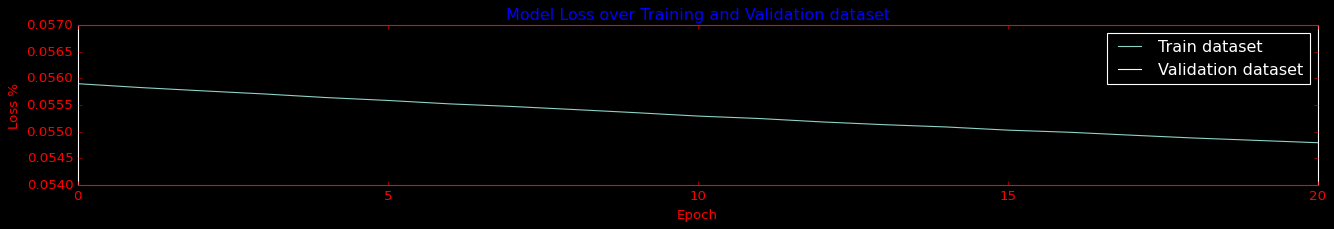

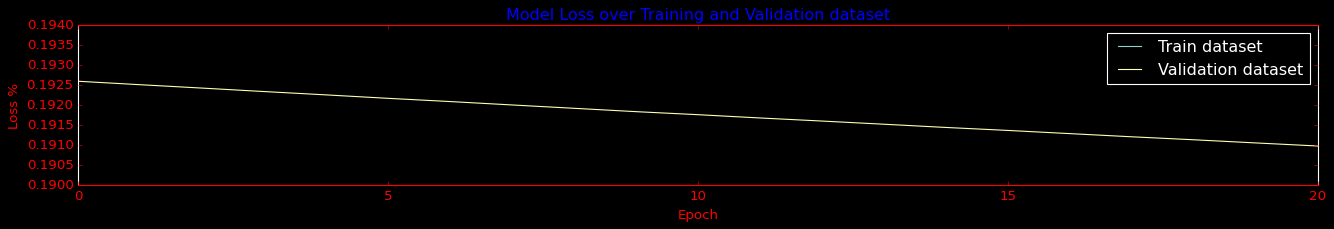

In [ ]:
plot_loss( model_fitting_obj= model_LSTM_fit, ylim=[0.054, 0.057], figsz=(20, 2.5) )
plot_loss( model_fitting_obj= model_LSTM_fit, ylim=[0.19, 0.194], figsz=(20, 2.5) )

#### Stacked LSTM model

In this model, we will be stacking multiple LSTM layers. That way the model will learn other abstractions of input data over time. In other words, representing the input data at different time scales.

To do that in Keras, we need to specify the parameter `return_sequences` in the LSTM layer preceding another LSTM layer.

In [ ]:
model_LSTM = keras.Sequential()

model_LSTM.add(  layer= LSTM( 16, input_shape= (win_sz,1), return_sequences= True )  )
model_LSTM.add(  layer= LSTM( 8, return_sequences= True )  )
model_LSTM.add(  layer= LSTM( 4, return_sequences= False )  )

model_LSTM.add(  layer= Dense( 1 )  )

model_LSTM.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= 'mae'  )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'auto', restore_best_weights= True, verbose= 1  )

model_LSTM_fit = model_LSTM.fit(  trn_genr, validation_data= valid_genr, callbacks= [earlyStopMonitor_obj], epochs= 1000, verbose= 1  )

Epoch 1/1000
5/5 [==============================] - 3s 185ms/step - loss: 0.0772 - val_loss: 0.2749
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0770 - val_loss: 0.2746
Epoch 3/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0768 - val_loss: 0.2742
Epoch 4/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0765 - val_loss: 0.2738
Epoch 5/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0763 - val_loss: 0.2735
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0761 - val_loss: 0.2731
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0759 - val_loss: 0.2727
Epoch 8/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0757 - val_loss: 0.2724
Epoch 9/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0755 - val_loss: 0.2720
Epoch 10/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0753 - val_loss: 0.2716
Epoch 11

In [ ]:
model_LSTM.evaluate( tst_genr )

3/3 [==============================] - 0s 3ms/step - loss: 0.1634


0.16343143582344055

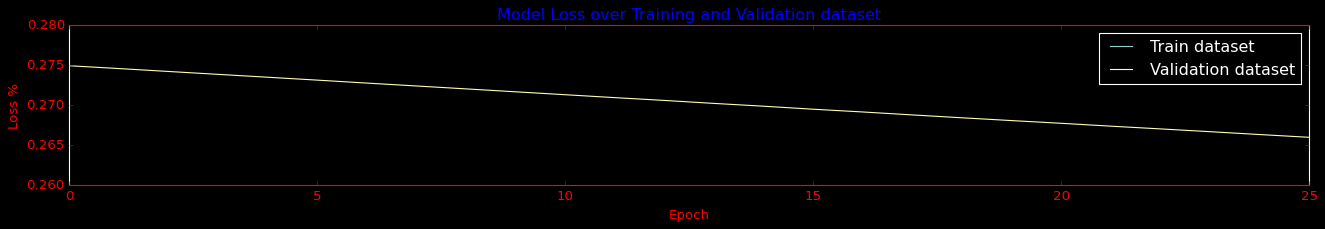

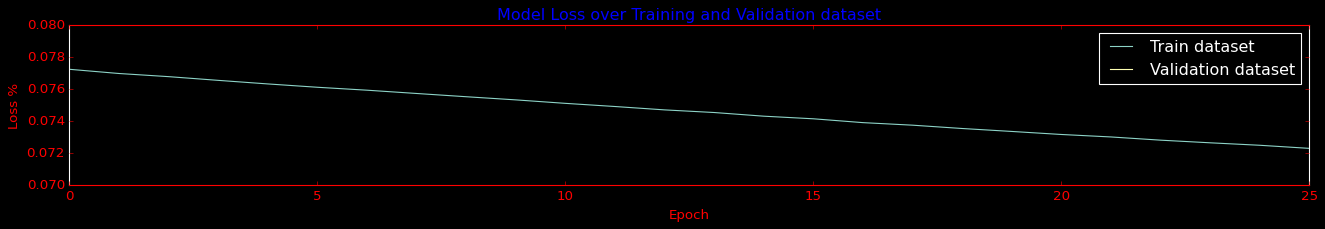

In [ ]:
plot_loss( model_fitting_obj= model_LSTM_fit, ylim=[0.26,0.28], figsz=(20, 2.5) )
plot_loss( model_fitting_obj= model_LSTM_fit, ylim=[0.07, 0.08], figsz=(20, 2.5) )